# Data Analysis Interview Challenge

In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(6,4))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
# load as Pandas dataframe
log_df = pd.read_json('Desktop/Springboard/17.2 ultimate_challenge/logins.json')
log_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
log_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


# Part 1 - Exploratory   data   analysis 
Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.

In [6]:
type(log_df['login_time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
#using a timedelta of 15 min, count how many logins fall in that time period. create new series of counts versus periods.
rng = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
ts = pd.Series(np.zeros(len(rng)), index=rng)

In [8]:
ts.head()

1970-01-01 20:00:00    0.0
1970-01-01 20:15:00    0.0
1970-01-01 20:30:00    0.0
1970-01-01 20:45:00    0.0
1970-01-01 21:00:00    0.0
Freq: 15T, dtype: float64

In [9]:
log_df = log_df.sort_values('login_time') # the login times were not in order, so this gets them aright.
log_df = log_df.reset_index(drop=True)
log_df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [10]:
p = 0 
for i in range(len(log_df)):
    s = ts.index[p] #start time
    e = ts.index[p+1] #end time
    t = log_df['login_time'][i]
    if s < t < e:
        ts[p] = ts[p] + 1
    else:
        while (e < t): #increment to the next time 
            p = p + 1 
            s = ts.index[p] #change start time
            e = ts.index[p+1] # change end time
        ts[p] = ts[p] + 1

In [12]:
ts.head()

1970-01-01 20:00:00    2.0
1970-01-01 20:15:00    6.0
1970-01-01 20:30:00    9.0
1970-01-01 20:45:00    7.0
1970-01-01 21:00:00    1.0
Freq: 15T, dtype: float64

In [13]:
ts.tail()

1970-04-13 18:00:00    5.0
1970-04-13 18:15:00    2.0
1970-04-13 18:30:00    7.0
1970-04-13 18:45:00    6.0
1970-04-13 19:00:00    0.0
Freq: 15T, dtype: float64

#### There appears to a be a regularity to the peaks and valleys (they follow a weekly basis as there are 4 crecendos each month)

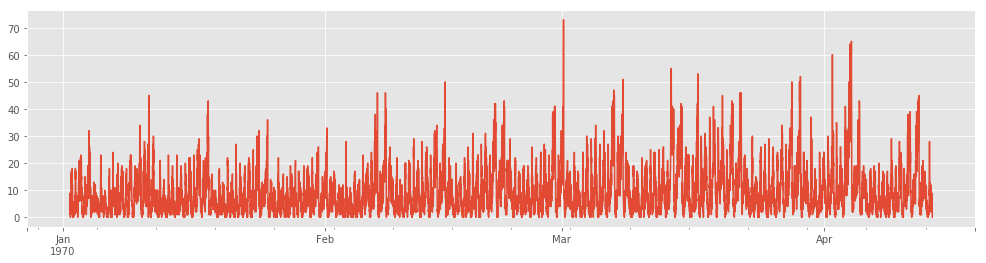

In [15]:
plt.figure(figsize=(17,4)) # The entire data set
ts.plot()

#### Looking at only the first week we can further see that the small undulations correspond to approximately 12 hours (the peaks are every 12 hours).

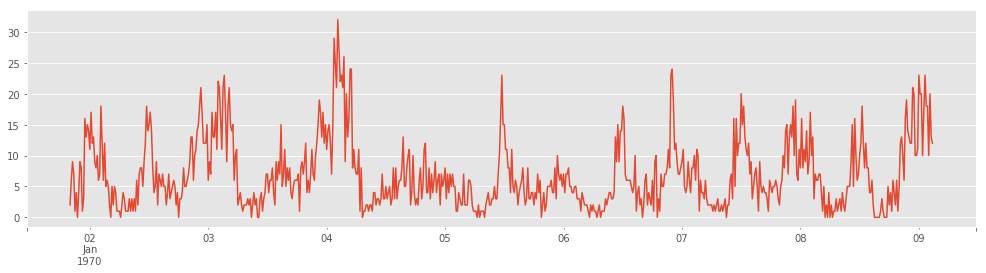

In [16]:
plt.figure(figsize=(17,4))# 1st week plot
ts[0:700].plot()

In [17]:
ts.max()

73.0

In [18]:
ts[ts == 73].index[0].dayofweek

6

#### The largest peak over all was a Sunday. And, for the first couple months that trend holds true (that activity peaks on the weekends and is low earlier in the week). However, the last month is much more random for peak activity - although the weekends are still consistently busy.

In [19]:
len(ts)/96/7

14.566964285714286

In [20]:
for i in range(14):
    print(ts[ts == ts[i*96*7:(i+1)*96*7].max()].index[0].dayofweek)

6
6
6
6
6
5
6
6
6
6
4
5
2
5


## Conclusion
The data suggests two major trends. The first is that activity generally peaks approximately every 12 hours (early morning and early afternoon). Second, activity generally builds over the course of the week, peaking on the weekend. Although this trend weakens in March, weekends can still be counted on to be busy (other days saw increased activity as well).

The biggest data quality issue was that the login times were randomly organized, but that has been sorted.

# Part 2 ‑ Experiment   and   metrics   design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

### Question 1:
What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

### My Answer:
I would choose weekend engagement for drivers in the city other than their primary weekday city. With the huge difference in peak times during the weekdays, it is unlikely that any driver would take advantage of both cities as that would equate to working more than 12 hours a day. However, with weekends being active for both throughout the day, it is more reasonable to expect a driver to take customers back and forth with tolls not being an issue.

### Question 2:
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: 

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the observation

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### My Answer: 

(a) I'm not sure how large the driver pool is, but tracking all of them initially would be helpful. Thus, prior to any announcements, I would track drivers' city habits both on weekdays and weekends. That is, I would track which cities are they spending the majority of their time, or are they split. Then I would inform all of them (the prior weeks serves as the control and it would be difficult to be sure drivers did not share the information if only a selection were chosen) of the changed toll policy. Again, their trips per city would be tracked. It would be especially noteworthy to note how many times the city location changes per day.

(b) I would use a t-test to compare the average number of trips back and forth as well as trips in the non-weekday city. I would also compute an effect size as the number of trips may make it easy to find significance so that we know if the difference is meaningful.

(c) If the the effect size is greater than .25 I would then compute an actual cost analysis to see if the cost of the program is outweighed by the extra money brought in. With both of those true I would encourage the policy to be made permanent.

# Part 3 -  Predictive   modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

#### Data description

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup 

● avg_rating_by_driver: the rider’s average rating over all of their trips 

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 

● surge_pct: the percent of trips taken with surge multiplier > 1 

● avg_surge: The average surge multiplier over all of this user’s trips 

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise 

● weekday_pct: the percent of the user’s trips occurring during a weekday 

In [21]:
with open('Desktop/Springboard/17.2 ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)

ultimate_df = pd.DataFrame(data)
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [22]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [23]:
ultimate_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [24]:
ultimate_df[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [25]:
ultimate_df['last_trip_date'][0] # Right now they are strings

'2014-06-17'

In [26]:
#this sequence runs through the dataframe, creates a date six months from the start date, and then checks if the last trip falls
#within a 30 days of that time. Then it ouputs a 1 or 0 to a list of active users.

active_users = []
for i in range(len(ultimate_df)):
    st = pd.Timestamp(ultimate_df['signup_date'][i]) #get start date
    et = st + pd.Timedelta('181D') #6 months later
    at = et - pd.Timedelta('30D') #set point 30 days prior
    if at <= pd.Timestamp(ultimate_df['last_trip_date'][i]) <= et:
        active_users.append([1]) # now that the active condition has been met, set active user to 1
    else:
        active_users.append([0])

In [27]:
df1 = pd.DataFrame(active_users,columns = ['active_users'])

In [28]:
df1['active_users'].value_counts()

0    37802
1    12198
Name: active_users, dtype: int64

In [29]:
12198/50000*100

24.396

### Continuous data

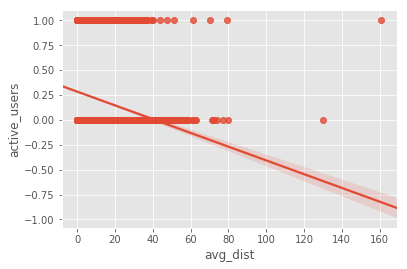

In [30]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_dist'], fit_reg = True)

It appears that the longer the average distance, the less likely one is to be active. This makes sense in that someone who is taking a one-time, longer trip may have been longer on average.

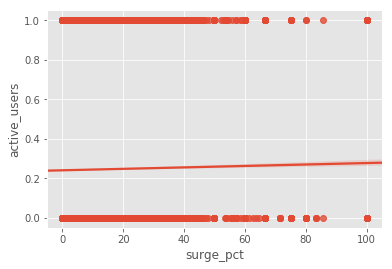

In [31]:
sns.regplot(y=df1['active_users'], x=ultimate_df['surge_pct'], fit_reg = True)

There is almost no correlation here.

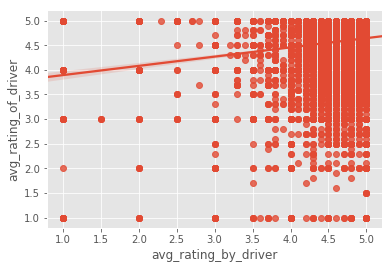

In [32]:
sns.regplot(y=ultimate_df['avg_rating_of_driver'], x=ultimate_df['avg_rating_by_driver'], fit_reg = True)

There is not as strong a correlation here as expected, so we will check each indvidually against active users.

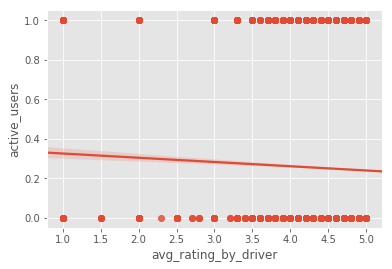

In [33]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_rating_by_driver'], fit_reg = True)

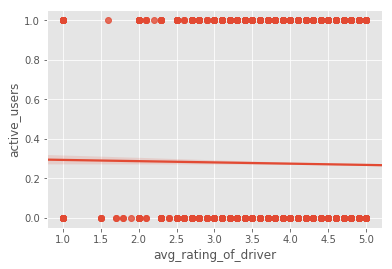

In [34]:
sns.regplot(y=df1['active_users'], x=ultimate_df['avg_rating_of_driver'], fit_reg = True)

Average rating by driver has a stronger (negative) correlation

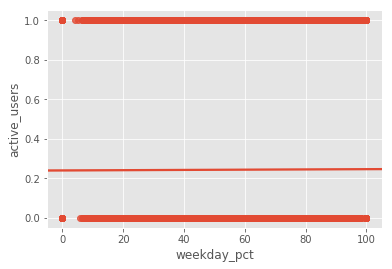

In [35]:
sns.regplot(y=df1['active_users'], x=ultimate_df['weekday_pct'], fit_reg = True)

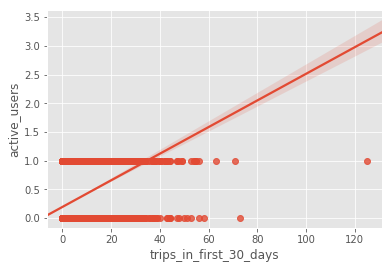

In [36]:
sns.regplot(y=df1['active_users'], x=ultimate_df['trips_in_first_30_days'], fit_reg = True)

It does have one dramatic outlier, but still thinks the correlation is strong.

### Categorical data

In [37]:
df = pd.concat([ultimate_df, df1], axis = 1)

In [38]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_users
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [39]:
# Table of ultimate balck vs active
ub_active = pd.crosstab(index=df["active_users"], 
                            columns=df["ultimate_black_user"],
                             margins=True)   # Include row and column totals

ub_active.columns = ["Not Ultimate Black","Is Ultimate Black","rowtotal"]
ub_active.index= ["Not Active","Is Active","coltotal"]

ub_active

,Not Ultimate Black,Is Ultimate Black,rowtotal
Not Active,25204,12598,37802
Is Active,5942,6256,12198
coltotal,31146,18854,50000


Ultimate Black looks like a good feature to include as more than half of active users are ultimate black users but less than 40% of overall users are ultimate black users. This is a significant jump in frequency.

In [40]:
# Table of phone type vs active
phone_active = pd.crosstab(index=df["active_users"], 
                            columns=df["phone"],
                             margins=True)   # Include row and column totals

phone_active.columns = ["Android","iPhone","rowtotal"]
phone_active.index= ["Not Active","Is Active","coltotal"]

phone_active

,Android,iPhone,rowtotal
Not Active,13096,24394,37490
Is Active,1926,10188,12114
coltotal,15022,34582,49604


While Android users make up about 30% of the total users, they only make up 15% of active users. So the phone type does seem to be an indicator.

In [41]:
# Table of ultimate balck vs active
city_active = pd.crosstab(index=df["active_users"], 
                            columns=df["city"],
                             margins=True)   # Include row and column totals

city_active.columns = ["Astapor","King's Landing",'Winterfell',"rowtotal"]
city_active.index= ["Not Active","Is Active","coltotal"]

city_active

,Astapor,King's Landing,Winterfell,rowtotal
Not Active,13838,6099,17865,37802
Is Active,2696,4031,5471,12198
coltotal,16534,10130,23336,50000


Astapor and King's Landing have ratios outside of the standard active/not active rate.

### Build predictive model

In [42]:
#transforming categorical features into numerical for predictive modeling
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['Astapor',"King's Landing",'Winterfell'])
LE = preprocessing.LabelEncoder()
LE.fit(['iPhone','Android'])

LabelEncoder()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active_users              50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.6+ MB


In [44]:
df_drop = df.dropna()

In [45]:
df_drop['active_users'].value_counts()

0    30209
1    11236
Name: active_users, dtype: int64

Looking at this new value_counts, the percentage of active users has only changed from 24.39 % to 24.47%, it appears that the ratio of the active users in the rows dropped is fairly consistent. So I will go ahead and drop the missing values.

In [46]:
df = df.dropna()
df = df.reset_index(drop = True)

In [47]:
creation1 = le.transform(df['city']) #transform the categorical data into number labels
creation2 = LE.transform(df['phone'])

In [48]:
df2 = pd.DataFrame(creation1,columns = ['city#']) # add them to the dataframe
df3 = pd.DataFrame(creation2, columns = ['phone#'])
df = pd.concat([df,df2,df3],axis =1 )

In [49]:
len(df)

41445

In [50]:
df = df.drop(['city','phone'], axis=1) # no need for old columns

In [51]:
#final cleaning step - change true/false labels to 1/0's. 
UB = []
for i in range(len(df)):
    if df['ultimate_black_user'][i] == True:
        UB.append([1]) 
    else:
        UB.append([0])
df4 = pd.DataFrame(UB,columns = ['UB'])
df4.head()

,UB
0,1
1,0
2,0
3,1
4,0


In [52]:
df = pd.concat([df,df4],axis =1 )
df = df.drop(['ultimate_black_user'], axis=1) # no need for old columns
df.head() #ready for model

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,active_users,city#,phone#,UB
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,0,1,1,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0,0,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1,1,1,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0,2,0,0


In [53]:
#splitting into features and target
y = df['active_users']
X = df[['avg_dist', 'avg_rating_by_driver','trips_in_first_30_days', 'city#', 'phone#','UB']]

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11677   375]
 [ 3949   577]]
              precision    recall  f1-score   support

           0       0.75      0.97      0.84     12052
           1       0.61      0.13      0.21      4526

    accuracy                           0.74     16578
   macro avg       0.68      0.55      0.53     16578
weighted avg       0.71      0.74      0.67     16578



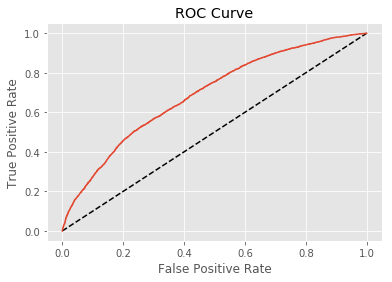

In [55]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv = 5,scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.6908361472798901
AUC scores computed using 5-fold cross-validation: [0.69648048 0.69118337 0.68945508 0.69698036 0.70472593]


In [57]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 19306.977288832535}
Best score is 0.7426227530462057


In [58]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [59]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Text(0,0.5,'Feature Importance Score')

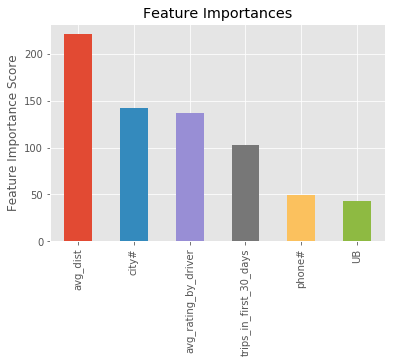

In [60]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [61]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.95%


## Conclusion
The approach was to determine the number of active users (about 24%), identify which continuous (numerical) data was correlated to activity, identify which categorical data was correlated to activity, and then build a model to predict active users. The model was accurate in approximately 78% of its predictions, although it was better at predicting correctly those that were not active than predicting those that were active correctly. The main concern is how active users are defined. The idea of the "sixth month" is not clear and even a shift of a few days dramatically changes the percentage of users considered active.

For the model, I initially used logistic regression as it is a solid predictor of binary classification. I think one way to improve the accuracy could be to normalize the features to minimize any bias from different scales. As is however, average distance was the most important feature. This implies that users who use the service for local, smaller trips are most likely to engage frequently and remain active. I would suggest focusing retention campaigns on those local users. If looking for new users, Astapor is the city to focus on as it had the worst rate. A comparison to King's Landing would be beneficial as those users are very active. It also seems that there is a better app experience for iPhone users, so improving the Android app would likely help.